In [10]:
#Copyright 2019, Seokjun Bu, Softcomputing LAB all rights reserved.
%matplotlib inline
import glob
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import Model, load_model
from keras.utils import np_utils, multi_gpu_model
from keras.callbacks import EarlyStopping
from keras.layers import Input, Lambda, concatenate, TimeDistributed, CuDNNLSTM, BatchNormalization, LSTM
from keras.layers.core import Dense, Dropout, Flatten, Reshape
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [20]:
def plot_history(model_input, mode='loss', title='Entropy'):
    history = model_input.history
    plt.plot(history.history[mode])
    plt.plot(history.history['val_'+mode])
    plt.title(title)
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [6]:
dataset = pd.read_pickle('../../dataset_tmp/fastcampus_school/2/dataset.pkl')
print(dataset.shape)

(32013, 18)


In [7]:
columns_with_d = list(dataset.columns)
columns_with_d.remove('date')
print(columns_with_d)
columns = list(dataset.columns)
columns.remove('date')
columns.remove('PM10')
columns.remove('PM25')
print(columns)

['timestamp', 'hour', 'weekday', 'Temp', 'Precipitation', 'Snowfall', 'Wind_speed', 'Wind_dir', 'Humidity', 'Air_pressure', 'NO2', 'O3', 'CO', 'SO2', 'PM10', 'PM25', 'bicycle_num']
['timestamp', 'hour', 'weekday', 'Temp', 'Precipitation', 'Snowfall', 'Wind_speed', 'Wind_dir', 'Humidity', 'Air_pressure', 'NO2', 'O3', 'CO', 'SO2', 'bicycle_num']


In [8]:
dataset_with_d = dataset[columns_with_d]
print(dataset_with_d.shape)
dataset_without_d = dataset[columns]
print(dataset_without_d.shape)

(32013, 17)
(32013, 15)


In [12]:
dataset_with_d_scaled = dataset_with_d.values
scaler = StandardScaler()
scaler.fit(dataset_with_d_scaled)
dataset_with_d_scaled = scaler.transform(dataset_with_d_scaled)
print(dataset_with_d_scaled)

[[-1.74833762 -1.66938168 -1.57289852 ... -0.62465308 -0.65028175
  -0.71099537]
 [-1.74823031 -1.52474079 -1.57289852 ... -0.64611593 -0.58141218
  -0.70995863]
 [-1.74758645 -0.65689545 -1.57289852 ... -0.80351013 -0.73751654
  -0.71099537]
 ...
 [ 1.72828908  1.51271788  0.63576892 ... -0.05087967  0.06137045
   2.79629764]
 [ 1.72839639  1.65735877  0.63576892 ... -0.55942988 -0.43219479
   1.87981906]
 [ 1.7285037  -1.66938168  0.63576892 ... -0.85215925 -0.89591654
   1.63514831]]


In [13]:
dataset_without_d_scaled = dataset_without_d.values
scaler = StandardScaler()
scaler.fit(dataset_without_d_scaled)
dataset_without_d_scaled = scaler.transform(dataset_without_d_scaled)
print(dataset_without_d_scaled)

[[-1.74833762 -1.66938168 -1.57289852 ... -0.33949181 -0.29584194
  -0.71099537]
 [-1.74823031 -1.52474079 -1.57289852 ... -0.35949782 -0.43799225
  -0.70995863]
 [-1.74758645 -0.65689545 -1.57289852 ... -0.6195759  -0.47352983
  -0.71099537]
 ...
 [ 1.72828908  1.51271788  0.63576892 ... -0.6195759  -0.43799225
   2.79629764]
 [ 1.72839639  1.65735877  0.63576892 ... -1.11972606 -0.89998075
   1.87981906]
 [ 1.7285037  -1.66938168  0.63576892 ... -1.29978012 -0.86444317
   1.63514831]]


(22409, 14) (22409,)
(9604, 14) (9604,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 14)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 120       
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 54        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 7         
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________
Train on 22409 samples, validate on 9604 samples
Epoch 1/500
 - 0s - loss: 1.0875 - acc: 0.0000e+00 - val_loss: 1.0302 - val_acc: 0.0000e+00
Epoch 2/500
 - 0s - loss: 1.0414 - acc: 0.0000e+00 - val_loss: 0.9885 - val_acc: 0.0000e+00
Epo

 - 0s - loss: 0.3036 - acc: 0.0000e+00 - val_loss: 0.3000 - val_acc: 0.0000e+00
Epoch 80/500
 - 0s - loss: 0.3017 - acc: 0.0000e+00 - val_loss: 0.2983 - val_acc: 0.0000e+00
Epoch 81/500
 - 0s - loss: 0.2998 - acc: 0.0000e+00 - val_loss: 0.2967 - val_acc: 0.0000e+00
Epoch 82/500
 - 0s - loss: 0.2980 - acc: 0.0000e+00 - val_loss: 0.2952 - val_acc: 0.0000e+00
Epoch 83/500
 - 0s - loss: 0.2963 - acc: 0.0000e+00 - val_loss: 0.2936 - val_acc: 0.0000e+00
Epoch 84/500
 - 0s - loss: 0.2946 - acc: 0.0000e+00 - val_loss: 0.2921 - val_acc: 0.0000e+00
Epoch 85/500
 - 0s - loss: 0.2930 - acc: 0.0000e+00 - val_loss: 0.2907 - val_acc: 0.0000e+00
Epoch 86/500
 - 0s - loss: 0.2915 - acc: 0.0000e+00 - val_loss: 0.2894 - val_acc: 0.0000e+00
Epoch 87/500
 - 0s - loss: 0.2900 - acc: 0.0000e+00 - val_loss: 0.2881 - val_acc: 0.0000e+00
Epoch 88/500
 - 0s - loss: 0.2886 - acc: 0.0000e+00 - val_loss: 0.2868 - val_acc: 0.0000e+00
Epoch 89/500
 - 0s - loss: 0.2872 - acc: 0.0000e+00 - val_loss: 0.2855 - val_acc: 0

Epoch 167/500
 - 0s - loss: 0.2288 - acc: 0.0000e+00 - val_loss: 0.2323 - val_acc: 0.0000e+00
Epoch 168/500
 - 0s - loss: 0.2282 - acc: 0.0000e+00 - val_loss: 0.2317 - val_acc: 0.0000e+00
Epoch 169/500
 - 0s - loss: 0.2279 - acc: 0.0000e+00 - val_loss: 0.2313 - val_acc: 0.0000e+00
Epoch 170/500
 - 0s - loss: 0.2274 - acc: 0.0000e+00 - val_loss: 0.2309 - val_acc: 0.0000e+00
Epoch 171/500
 - 0s - loss: 0.2269 - acc: 0.0000e+00 - val_loss: 0.2305 - val_acc: 0.0000e+00
Epoch 172/500
 - 0s - loss: 0.2264 - acc: 0.0000e+00 - val_loss: 0.2300 - val_acc: 0.0000e+00
Epoch 173/500
 - 0s - loss: 0.2259 - acc: 0.0000e+00 - val_loss: 0.2295 - val_acc: 0.0000e+00
Epoch 174/500
 - 0s - loss: 0.2255 - acc: 0.0000e+00 - val_loss: 0.2290 - val_acc: 0.0000e+00
Epoch 175/500
 - 0s - loss: 0.2249 - acc: 0.0000e+00 - val_loss: 0.2286 - val_acc: 0.0000e+00
Epoch 176/500
 - 0s - loss: 0.2246 - acc: 0.0000e+00 - val_loss: 0.2284 - val_acc: 0.0000e+00
Epoch 177/500
 - 0s - loss: 0.2242 - acc: 0.0000e+00 - val_l

Epoch 255/500
 - 0s - loss: 0.1977 - acc: 0.0000e+00 - val_loss: 0.2026 - val_acc: 0.0000e+00
Epoch 256/500
 - 0s - loss: 0.1975 - acc: 0.0000e+00 - val_loss: 0.2027 - val_acc: 0.0000e+00
Epoch 257/500
 - 0s - loss: 0.1972 - acc: 0.0000e+00 - val_loss: 0.2024 - val_acc: 0.0000e+00
Epoch 258/500
 - 0s - loss: 0.1970 - acc: 0.0000e+00 - val_loss: 0.2021 - val_acc: 0.0000e+00
Epoch 259/500
 - 0s - loss: 0.1968 - acc: 0.0000e+00 - val_loss: 0.2019 - val_acc: 0.0000e+00
Epoch 260/500
 - 0s - loss: 0.1965 - acc: 0.0000e+00 - val_loss: 0.2017 - val_acc: 0.0000e+00
Epoch 261/500
 - 0s - loss: 0.1963 - acc: 0.0000e+00 - val_loss: 0.2015 - val_acc: 0.0000e+00
Epoch 262/500
 - 0s - loss: 0.1961 - acc: 0.0000e+00 - val_loss: 0.2015 - val_acc: 0.0000e+00
Epoch 263/500
 - 0s - loss: 0.1958 - acc: 0.0000e+00 - val_loss: 0.2012 - val_acc: 0.0000e+00
Epoch 264/500
 - 0s - loss: 0.1957 - acc: 0.0000e+00 - val_loss: 0.2009 - val_acc: 0.0000e+00
Epoch 265/500
 - 0s - loss: 0.1955 - acc: 0.0000e+00 - val_l

Epoch 343/500
 - 0s - loss: 0.1830 - acc: 0.0000e+00 - val_loss: 0.1893 - val_acc: 0.0000e+00
Epoch 344/500
 - 0s - loss: 0.1830 - acc: 0.0000e+00 - val_loss: 0.1891 - val_acc: 0.0000e+00
Epoch 345/500
 - 0s - loss: 0.1828 - acc: 0.0000e+00 - val_loss: 0.1890 - val_acc: 0.0000e+00
Epoch 346/500
 - 0s - loss: 0.1827 - acc: 0.0000e+00 - val_loss: 0.1888 - val_acc: 0.0000e+00
Epoch 347/500
 - 0s - loss: 0.1826 - acc: 0.0000e+00 - val_loss: 0.1887 - val_acc: 0.0000e+00
Epoch 348/500
 - 0s - loss: 0.1827 - acc: 0.0000e+00 - val_loss: 0.1884 - val_acc: 0.0000e+00
Epoch 349/500
 - 0s - loss: 0.1823 - acc: 0.0000e+00 - val_loss: 0.1887 - val_acc: 0.0000e+00
Epoch 350/500
 - 0s - loss: 0.1824 - acc: 0.0000e+00 - val_loss: 0.1884 - val_acc: 0.0000e+00
Epoch 351/500
 - 0s - loss: 0.1822 - acc: 0.0000e+00 - val_loss: 0.1885 - val_acc: 0.0000e+00
Epoch 352/500
 - 0s - loss: 0.1821 - acc: 0.0000e+00 - val_loss: 0.1884 - val_acc: 0.0000e+00
Epoch 353/500
 - 0s - loss: 0.1819 - acc: 0.0000e+00 - val_l

Epoch 431/500
 - 0s - loss: 0.1752 - acc: 0.0000e+00 - val_loss: 0.1821 - val_acc: 0.0000e+00
Epoch 432/500
 - 0s - loss: 0.1749 - acc: 0.0000e+00 - val_loss: 0.1821 - val_acc: 0.0000e+00
Epoch 433/500
 - 0s - loss: 0.1750 - acc: 0.0000e+00 - val_loss: 0.1820 - val_acc: 0.0000e+00
Epoch 434/500
 - 0s - loss: 0.1748 - acc: 0.0000e+00 - val_loss: 0.1822 - val_acc: 0.0000e+00
Epoch 435/500
 - 0s - loss: 0.1749 - acc: 0.0000e+00 - val_loss: 0.1817 - val_acc: 0.0000e+00
Epoch 436/500
 - 0s - loss: 0.1746 - acc: 0.0000e+00 - val_loss: 0.1820 - val_acc: 0.0000e+00
Epoch 437/500
 - 0s - loss: 0.1747 - acc: 0.0000e+00 - val_loss: 0.1817 - val_acc: 0.0000e+00
Epoch 438/500
 - 0s - loss: 0.1745 - acc: 0.0000e+00 - val_loss: 0.1819 - val_acc: 0.0000e+00
Epoch 439/500
 - 0s - loss: 0.1746 - acc: 0.0000e+00 - val_loss: 0.1819 - val_acc: 0.0000e+00
Epoch 440/500
 - 0s - loss: 0.1744 - acc: 0.0000e+00 - val_loss: 0.1815 - val_acc: 0.0000e+00
Epoch 441/500
 - 0s - loss: 0.1743 - acc: 0.0000e+00 - val_l

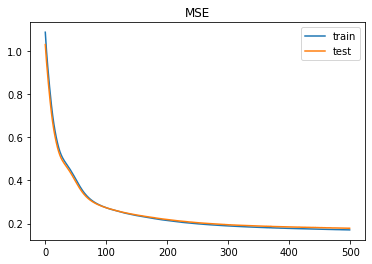

In [24]:
#1 without D
# X, Y, Split
X, Y = dataset_without_d_scaled[:, :-1], dataset_without_d_scaled[:, -1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, random_state=11)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
# Build Model
n_input = Input(shape=(X_train.shape[1],))
H = Dense(8, activation='tanh')(n_input)
H = Dense(6, activation='tanh')(H)
n_output = Dense(1, activation='linear')(H)
mlp_model = Model(n_input, n_output)
mlp_model.summary()
mlp_model.compile(loss='mse', optimizer='adam', metrics=['acc'])
# Fitting
history_mlp_model_1 = mlp_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=500, batch_size=4096, verbose=2)
# Visualize Curve
plot_history(mlp_model, mode='loss', title='MSE')

(22409, 16) (22409,)
(9604, 16) (9604,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 54        
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 7         
Total params: 197
Trainable params: 197
Non-trainable params: 0
_________________________________________________________________
Train on 22409 samples, validate on 9604 samples
Epoch 1/500
 - 0s - loss: 1.0383 - acc: 0.0000e+00 - val_loss: 0.9471 - val_acc: 0.0000e+00
Epoch 2/500
 - 0s - loss: 0.9688 - acc: 0.0000e+00 - val_loss: 0.8851 - val_acc: 0.0000e+00
Epo

 - 0s - loss: 0.3336 - acc: 0.0000e+00 - val_loss: 0.3210 - val_acc: 0.0000e+00
Epoch 80/500
 - 0s - loss: 0.3310 - acc: 0.0000e+00 - val_loss: 0.3186 - val_acc: 0.0000e+00
Epoch 81/500
 - 0s - loss: 0.3284 - acc: 0.0000e+00 - val_loss: 0.3163 - val_acc: 0.0000e+00
Epoch 82/500
 - 0s - loss: 0.3259 - acc: 0.0000e+00 - val_loss: 0.3141 - val_acc: 0.0000e+00
Epoch 83/500
 - 0s - loss: 0.3236 - acc: 0.0000e+00 - val_loss: 0.3118 - val_acc: 0.0000e+00
Epoch 84/500
 - 0s - loss: 0.3212 - acc: 0.0000e+00 - val_loss: 0.3097 - val_acc: 0.0000e+00
Epoch 85/500
 - 0s - loss: 0.3188 - acc: 0.0000e+00 - val_loss: 0.3076 - val_acc: 0.0000e+00
Epoch 86/500
 - 0s - loss: 0.3166 - acc: 0.0000e+00 - val_loss: 0.3056 - val_acc: 0.0000e+00
Epoch 87/500
 - 0s - loss: 0.3144 - acc: 0.0000e+00 - val_loss: 0.3036 - val_acc: 0.0000e+00
Epoch 88/500
 - 0s - loss: 0.3123 - acc: 0.0000e+00 - val_loss: 0.3017 - val_acc: 0.0000e+00
Epoch 89/500
 - 0s - loss: 0.3102 - acc: 0.0000e+00 - val_loss: 0.2999 - val_acc: 0

Epoch 167/500
 - 0s - loss: 0.2370 - acc: 0.0000e+00 - val_loss: 0.2368 - val_acc: 0.0000e+00
Epoch 168/500
 - 0s - loss: 0.2364 - acc: 0.0000e+00 - val_loss: 0.2362 - val_acc: 0.0000e+00
Epoch 169/500
 - 0s - loss: 0.2359 - acc: 0.0000e+00 - val_loss: 0.2357 - val_acc: 0.0000e+00
Epoch 170/500
 - 0s - loss: 0.2353 - acc: 0.0000e+00 - val_loss: 0.2353 - val_acc: 0.0000e+00
Epoch 171/500
 - 0s - loss: 0.2348 - acc: 0.0000e+00 - val_loss: 0.2348 - val_acc: 0.0000e+00
Epoch 172/500
 - 0s - loss: 0.2344 - acc: 0.0000e+00 - val_loss: 0.2344 - val_acc: 0.0000e+00
Epoch 173/500
 - 0s - loss: 0.2339 - acc: 0.0000e+00 - val_loss: 0.2339 - val_acc: 0.0000e+00
Epoch 174/500
 - 0s - loss: 0.2335 - acc: 0.0000e+00 - val_loss: 0.2334 - val_acc: 0.0000e+00
Epoch 175/500
 - 0s - loss: 0.2329 - acc: 0.0000e+00 - val_loss: 0.2332 - val_acc: 0.0000e+00
Epoch 176/500
 - 0s - loss: 0.2325 - acc: 0.0000e+00 - val_loss: 0.2328 - val_acc: 0.0000e+00
Epoch 177/500
 - 0s - loss: 0.2320 - acc: 0.0000e+00 - val_l

Epoch 255/500
 - 0s - loss: 0.2059 - acc: 0.0000e+00 - val_loss: 0.2088 - val_acc: 0.0000e+00
Epoch 256/500
 - 0s - loss: 0.2054 - acc: 0.0000e+00 - val_loss: 0.2089 - val_acc: 0.0000e+00
Epoch 257/500
 - 0s - loss: 0.2052 - acc: 0.0000e+00 - val_loss: 0.2085 - val_acc: 0.0000e+00
Epoch 258/500
 - 0s - loss: 0.2050 - acc: 0.0000e+00 - val_loss: 0.2082 - val_acc: 0.0000e+00
Epoch 259/500
 - 0s - loss: 0.2048 - acc: 0.0000e+00 - val_loss: 0.2083 - val_acc: 0.0000e+00
Epoch 260/500
 - 0s - loss: 0.2044 - acc: 0.0000e+00 - val_loss: 0.2077 - val_acc: 0.0000e+00
Epoch 261/500
 - 0s - loss: 0.2042 - acc: 0.0000e+00 - val_loss: 0.2075 - val_acc: 0.0000e+00
Epoch 262/500
 - 0s - loss: 0.2041 - acc: 0.0000e+00 - val_loss: 0.2073 - val_acc: 0.0000e+00
Epoch 263/500
 - 0s - loss: 0.2037 - acc: 0.0000e+00 - val_loss: 0.2073 - val_acc: 0.0000e+00
Epoch 264/500
 - 0s - loss: 0.2036 - acc: 0.0000e+00 - val_loss: 0.2071 - val_acc: 0.0000e+00
Epoch 265/500
 - 0s - loss: 0.2033 - acc: 0.0000e+00 - val_l

Epoch 343/500
 - 0s - loss: 0.1882 - acc: 0.0000e+00 - val_loss: 0.1936 - val_acc: 0.0000e+00
Epoch 344/500
 - 0s - loss: 0.1881 - acc: 0.0000e+00 - val_loss: 0.1935 - val_acc: 0.0000e+00
Epoch 345/500
 - 0s - loss: 0.1880 - acc: 0.0000e+00 - val_loss: 0.1933 - val_acc: 0.0000e+00
Epoch 346/500
 - 0s - loss: 0.1878 - acc: 0.0000e+00 - val_loss: 0.1929 - val_acc: 0.0000e+00
Epoch 347/500
 - 0s - loss: 0.1876 - acc: 0.0000e+00 - val_loss: 0.1936 - val_acc: 0.0000e+00
Epoch 348/500
 - 0s - loss: 0.1874 - acc: 0.0000e+00 - val_loss: 0.1928 - val_acc: 0.0000e+00
Epoch 349/500
 - 0s - loss: 0.1874 - acc: 0.0000e+00 - val_loss: 0.1929 - val_acc: 0.0000e+00
Epoch 350/500
 - 0s - loss: 0.1871 - acc: 0.0000e+00 - val_loss: 0.1931 - val_acc: 0.0000e+00
Epoch 351/500
 - 0s - loss: 0.1869 - acc: 0.0000e+00 - val_loss: 0.1924 - val_acc: 0.0000e+00
Epoch 352/500
 - 0s - loss: 0.1867 - acc: 0.0000e+00 - val_loss: 0.1926 - val_acc: 0.0000e+00
Epoch 353/500
 - 0s - loss: 0.1865 - acc: 0.0000e+00 - val_l

Epoch 431/500
 - 0s - loss: 0.1756 - acc: 0.0000e+00 - val_loss: 0.1823 - val_acc: 0.0000e+00
Epoch 432/500
 - 0s - loss: 0.1754 - acc: 0.0000e+00 - val_loss: 0.1819 - val_acc: 0.0000e+00
Epoch 433/500
 - 0s - loss: 0.1752 - acc: 0.0000e+00 - val_loss: 0.1825 - val_acc: 0.0000e+00
Epoch 434/500
 - 0s - loss: 0.1752 - acc: 0.0000e+00 - val_loss: 0.1819 - val_acc: 0.0000e+00
Epoch 435/500
 - 0s - loss: 0.1750 - acc: 0.0000e+00 - val_loss: 0.1820 - val_acc: 0.0000e+00
Epoch 436/500
 - 0s - loss: 0.1749 - acc: 0.0000e+00 - val_loss: 0.1818 - val_acc: 0.0000e+00
Epoch 437/500
 - 0s - loss: 0.1747 - acc: 0.0000e+00 - val_loss: 0.1818 - val_acc: 0.0000e+00
Epoch 438/500
 - 0s - loss: 0.1747 - acc: 0.0000e+00 - val_loss: 0.1814 - val_acc: 0.0000e+00
Epoch 439/500
 - 0s - loss: 0.1746 - acc: 0.0000e+00 - val_loss: 0.1815 - val_acc: 0.0000e+00
Epoch 440/500
 - 0s - loss: 0.1744 - acc: 0.0000e+00 - val_loss: 0.1814 - val_acc: 0.0000e+00
Epoch 441/500
 - 0s - loss: 0.1744 - acc: 0.0000e+00 - val_l

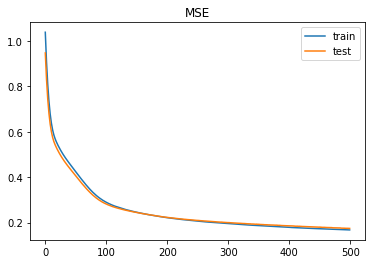

In [25]:
#1 with D
# X, Y, Split
X, Y = dataset_with_d_scaled[:, :-1], dataset_with_d_scaled[:, -1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, random_state=11)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
# Build Model
n_input = Input(shape=(X_train.shape[1],))
H = Dense(8, activation='tanh')(n_input)
H = Dense(6, activation='tanh')(H)
n_output = Dense(1, activation='linear')(H)
mlp_model = Model(n_input, n_output)
mlp_model.summary()
mlp_model.compile(loss='mse', optimizer='adam', metrics=['acc'])
# Fitting
history_mlp_model_1 = mlp_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=500, batch_size=4096, verbose=2)
# Visualize Curve
plot_history(mlp_model, mode='loss', title='MSE')